In [32]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier
import os
import gc
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
OriginDataDir = '/home/songyue/homeCredit/HomeCreditDefaultRisk/Data/OriginData'
TrainTestDataDir = '/home/songyue/homeCredit/HomeCreditDefaultRisk/Data/TrainTestData'
ModelSaveDir = '/home/songyue/homeCredit/HomeCreditDefaultRisk/Models/XGBoost/models'
ResultSaveDir = 'result'

In [2]:
def loadData(DataName):
    DataPath = os.path.join(TrainTestDataDir, DataName)
    if not os.path.exists(DataPath):
        print('%s does not exist!' % DataPath)
        return
    OriginData = pd.read_csv(DataPath, index_col=0)
    #OriginData = OriginData.sample(frac=1)  # 打乱顺序后返回
    return OriginData

In [3]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:50].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('XGBOOST Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('XGBOOST_ImportantFeats.png')

In [29]:
TestData = loadData('AllTest_withnull.csv')
TestID = TestData.SK_ID_CURR.values
#TestData.drop('SK_ID_CURR', axis=1, inplace=True)
AllTrainData = loadData('AllTrain_withnull.csv')
AllTrainData.reset_index(drop=True, inplace=True)
#AllTrainData.drop('SK_ID_CURR', axis=1, inplace=True)

In [5]:
AllTrainData.shape

(307511, 1340)

In [6]:
TestData.shape

(48744, 1339)

In [8]:
features = [x for x in AllTrainData.columns if x != 'TARGET' and x != 'SK_ID_CURR']

In [9]:
features

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'TOTALAREA_MODE',
 'EMERGENCYSTATE_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ

In [10]:
len(features)

1339

In [ ]:
featuresnew = [i for i in features if i not in featsDrop]
len(featuresnew)

In [30]:
df_train = AllTrainData
df_test = TestData
num_folds = 5
stratified = True
debug= False
del AllTrainData
del TestData
gc.collect()

27023

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 1340 entries, NAME_CONTRACT_TYPE to TARGET
dtypes: float64(1182), int64(158)
memory usage: 3.1 GB


In [14]:
# Divide in training/validation and test data
print("Starting LGBM. Train shape: {}, test shape: {}".format(df_train.shape, df_test.shape))
print("Num of Feature:",len(features))
# Cross validation model
if stratified:
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=90210)
else:
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=90210)
# Create arrays and dataframes to store results
oof_preds = np.zeros(df_train.shape[0])
sub_preds = np.zeros([df_test.shape[0],num_folds])
roc_score_list = []
feature_importance_df = pd.DataFrame()
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[features], df_train['TARGET'])):
    train_x, train_y = df_train[features].iloc[train_idx], df_train['TARGET'].iloc[train_idx]
    valid_x, valid_y = df_train[features].iloc[valid_idx], df_train['TARGET'].iloc[valid_idx]

    clf = lgb.LGBMClassifier(is_unbalance=False,
                               scale_pos_weight = 1,
                               reg_alpha=0.0,
                               reg_lambda=180,
                               min_split_gain=0.5,
                               colsample_bytree=0.03,
                               subsample_freq=1,
                               subsample=1,
                               min_child_samples=70,
                               num_leaves=30,
                               max_depth=-1,
                               max_bin=300,
                               learning_rate=0.02,
                               n_estimators=10000,
                               boosting_type='gbdt',
                               application="binary",
                               num_threads = -1
                              )

    clf.fit(train_x, train_y, eval_metric='auc',
              eval_set=[(valid_x, valid_y), (train_x, train_y)],
              eval_names=['valid', 'train'], early_stopping_rounds=100, verbose=200)
    
    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds[:,n_fold]= clf.predict_proba(df_test[features], num_iteration=clf.best_iteration_)[:, 1] 
    roc_curr = roc_auc_score(valid_y, oof_preds[valid_idx])
    roc_score_list.append(roc_curr)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_curr ))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

Starting LGBM. Train shape: (307511, 1340), test shape: (48744, 1339)
Num of Feature: 1339


/usr/share/anaconda2/envs/py3/lib/python3.5/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/usr/share/anaconda2/envs/py3/lib/python3.5/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/usr/share/anaconda2/envs/py3/lib/python3.5/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/usr/share/anaconda2/envs/py3/lib/python3.5

Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.775402	valid's auc: 0.771567
[400]	train's auc: 0.79466	valid's auc: 0.783883
[600]	train's auc: 0.806293	valid's auc: 0.7896
[800]	train's auc: 0.815843	valid's auc: 0.793281
[1000]	train's auc: 0.823952	valid's auc: 0.79548
[1200]	train's auc: 0.831205	valid's auc: 0.797042
[1400]	train's auc: 0.837863	valid's auc: 0.798004
[1600]	train's auc: 0.84391	valid's auc: 0.798761
[1800]	train's auc: 0.849656	valid's auc: 0.799144
[2000]	train's auc: 0.854895	valid's auc: 0.799472
[2200]	train's auc: 0.859944	valid's auc: 0.799721
[2400]	train's auc: 0.864731	valid's auc: 0.799878
[2600]	train's auc: 0.869259	valid's auc: 0.79999
[2800]	train's auc: 0.873478	valid's auc: 0.800152
[3000]	train's auc: 0.877597	valid's auc: 0.800186
Early stopping, best iteration is:
[2928]	train's auc: 0.876121	valid's auc: 0.800208
Fold  1 AUC : 0.800208


/usr/share/anaconda2/envs/py3/lib/python3.5/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/usr/share/anaconda2/envs/py3/lib/python3.5/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/usr/share/anaconda2/envs/py3/lib/python3.5/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/usr/share/anaconda2/envs/py3/lib/python3.5

Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.776841	valid's auc: 0.764245
[400]	train's auc: 0.796061	valid's auc: 0.776978
[600]	train's auc: 0.80793	valid's auc: 0.782652
[800]	train's auc: 0.817432	valid's auc: 0.786168
[1000]	train's auc: 0.82548	valid's auc: 0.788262
[1200]	train's auc: 0.83261	valid's auc: 0.789682
[1400]	train's auc: 0.839057	valid's auc: 0.790776
[1600]	train's auc: 0.845157	valid's auc: 0.791463
[1800]	train's auc: 0.850719	valid's auc: 0.792039
[2000]	train's auc: 0.855864	valid's auc: 0.792485
[2200]	train's auc: 0.860801	valid's auc: 0.792975
[2400]	train's auc: 0.865656	valid's auc: 0.793227
Early stopping, best iteration is:
[2453]	train's auc: 0.866829	valid's auc: 0.793356
Fold  2 AUC : 0.793357


/usr/share/anaconda2/envs/py3/lib/python3.5/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/usr/share/anaconda2/envs/py3/lib/python3.5/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/usr/share/anaconda2/envs/py3/lib/python3.5/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/usr/share/anaconda2/envs/py3/lib/python3.5

Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.776627	valid's auc: 0.76152
[400]	train's auc: 0.796138	valid's auc: 0.775902
[600]	train's auc: 0.807858	valid's auc: 0.781897
[800]	train's auc: 0.817322	valid's auc: 0.785647
[1000]	train's auc: 0.825393	valid's auc: 0.788008
[1200]	train's auc: 0.832546	valid's auc: 0.78962
[1400]	train's auc: 0.838926	valid's auc: 0.790732
[1600]	train's auc: 0.844903	valid's auc: 0.79157
[1800]	train's auc: 0.850405	valid's auc: 0.792213
[2000]	train's auc: 0.855598	valid's auc: 0.792578
[2200]	train's auc: 0.860557	valid's auc: 0.792941
[2400]	train's auc: 0.865212	valid's auc: 0.793129
Early stopping, best iteration is:
[2447]	train's auc: 0.86624	valid's auc: 0.793167
Fold  3 AUC : 0.793167


/usr/share/anaconda2/envs/py3/lib/python3.5/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/usr/share/anaconda2/envs/py3/lib/python3.5/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/usr/share/anaconda2/envs/py3/lib/python3.5/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/usr/share/anaconda2/envs/py3/lib/python3.5

Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.775868	valid's auc: 0.763618
[400]	train's auc: 0.795246	valid's auc: 0.778324
[600]	train's auc: 0.806856	valid's auc: 0.78457
[800]	train's auc: 0.81625	valid's auc: 0.788169
[1000]	train's auc: 0.824307	valid's auc: 0.790815
[1200]	train's auc: 0.831531	valid's auc: 0.792438
[1400]	train's auc: 0.837887	valid's auc: 0.793538
[1600]	train's auc: 0.843856	valid's auc: 0.794367
[1800]	train's auc: 0.849417	valid's auc: 0.794995
[2000]	train's auc: 0.854723	valid's auc: 0.795548
[2200]	train's auc: 0.859742	valid's auc: 0.79596
[2400]	train's auc: 0.864487	valid's auc: 0.796375
[2600]	train's auc: 0.868977	valid's auc: 0.796703
[2800]	train's auc: 0.873189	valid's auc: 0.796916
[3000]	train's auc: 0.877148	valid's auc: 0.796995
Early stopping, best iteration is:
[2928]	train's auc: 0.875743	valid's auc: 0.797041
Fold  4 AUC : 0.797042


/usr/share/anaconda2/envs/py3/lib/python3.5/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/usr/share/anaconda2/envs/py3/lib/python3.5/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/usr/share/anaconda2/envs/py3/lib/python3.5/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/usr/share/anaconda2/envs/py3/lib/python3.5

Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.777609	valid's auc: 0.763113
[400]	train's auc: 0.796227	valid's auc: 0.775611
[600]	train's auc: 0.807742	valid's auc: 0.78168
[800]	train's auc: 0.817135	valid's auc: 0.785571
[1000]	train's auc: 0.825181	valid's auc: 0.787931
[1200]	train's auc: 0.832187	valid's auc: 0.789586
[1400]	train's auc: 0.838601	valid's auc: 0.790672
[1600]	train's auc: 0.844585	valid's auc: 0.791603
[1800]	train's auc: 0.850091	valid's auc: 0.7924
[2000]	train's auc: 0.855356	valid's auc: 0.792877
[2200]	train's auc: 0.860254	valid's auc: 0.793293
[2400]	train's auc: 0.864868	valid's auc: 0.793695
[2600]	train's auc: 0.869371	valid's auc: 0.793865
[2800]	train's auc: 0.873569	valid's auc: 0.794153
[3000]	train's auc: 0.877557	valid's auc: 0.794349
[3200]	train's auc: 0.881407	valid's auc: 0.794389
Early stopping, best iteration is:
[3149]	train's auc: 0.880395	valid's auc: 0.794424
Fold  5 AUC : 0.794425


In [16]:
np.mean(roc_score_list)

0.7956396937988336

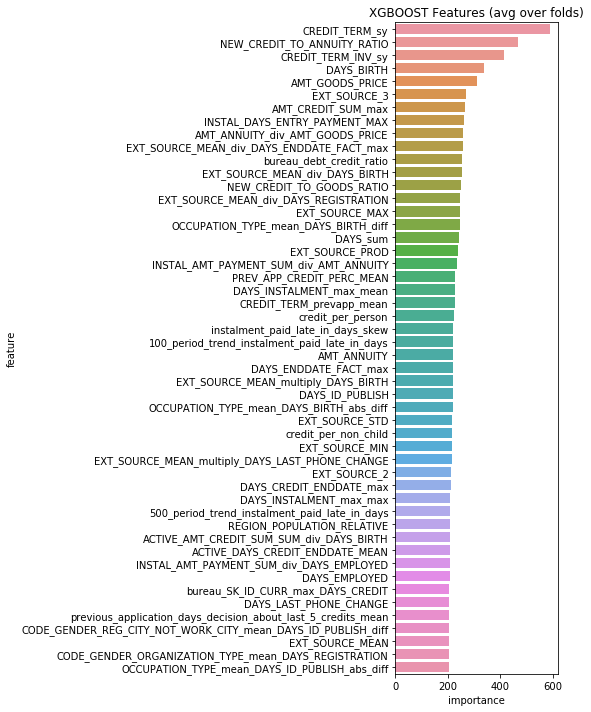

In [17]:
display_importances(fold_importance_df)

In [18]:
#用于提交test的函数
def calculate_rank(predictions):
    rank = (1 + predictions.rank().values) / (predictions.shape[0] + 1)
    return rank
def subtest(sub_preds_):
    subtmp = pd.DataFrame({'fold%d'%i:sub_preds_[:,i] for i in range(sub_preds_.shape[1])})
    pred = []
    for i in range(subtmp.shape[1]):
        pred.append(calculate_rank(subtmp['fold%d'%i]))
    submission = pd.DataFrame({'SK_ID_CURR': TestID, 'TARGET': np.mean(pred,axis=0)})
    subtmp['SK_ID_CURR'] = TestID
    return subtmp,submission
#获取特征重要度的函数
def get_importances(feature_importance_df_):
    importances = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)
    return importances

In [19]:
subtmp,sub = subtest(sub_preds)
importance = get_importances(fold_importance_df)

In [33]:
#保存数据
SaveDirPath = os.path.join(ResultSaveDir,'lgb1')
if not os.path.exists(SaveDirPath):
    os.mkdir(SaveDirPath)
importance.to_csv(os.path.join(SaveDirPath,"importance_lgb1.csv"))
sub.to_csv(os.path.join(SaveDirPath,"sub_lgb1.csv"), index=False)
subtmp.to_csv(os.path.join(SaveDirPath,"oof_test_lgb1.csv"), index=False)
oof_train_lgb = pd.DataFrame({'SK_ID_CURR': df_train['SK_ID_CURR'], 'pred': oof_preds})
oof_train_lgb.to_csv(os.path.join(SaveDirPath,"oof_train_lgb1.csv"), index=False)

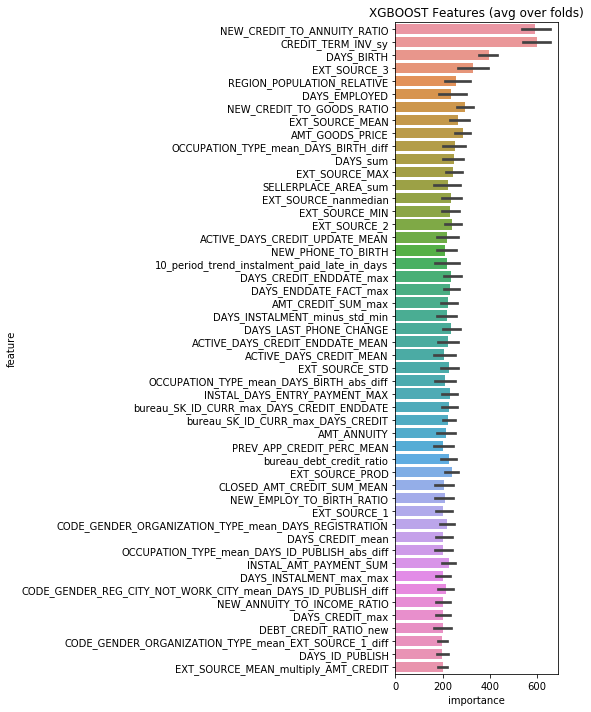

In [63]:
display_importances(feature_importance_df)

In [23]:
def calculate_rank(predictions):
    rank = (1 + predictions.rank().values) / (predictions.shape[0] + 1)
    return rank

In [24]:
subtmp = pd.DataFrame({'fold%d'%i:sub_preds[:,i] for i in range(sub_preds.shape[1])})
subtmp.head()

,fold0,fold1,fold2,fold3,fold4
0,0.054349,0.041344,0.037462,0.040675,0.046990
1,0.121563,0.147767,0.153325,0.131659,0.158578
2,0.046929,0.024696,0.035804,0.032607,0.027685
3,0.038838,0.032840,0.029656,0.035021,0.032957
4,0.158957,0.161895,0.155113,0.139859,0.124457


In [66]:
calculate_rank(subtmp['fold0'])

array([0.51789927, 0.90152836, 0.45984204, ..., 0.05020002, 0.22314083,
       0.87725921])

In [67]:
sub_preds

array([[0.04213572, 0.03703857, 0.05236077, 0.03521387, 0.03933048],
       [0.17388806, 0.09470553, 0.10199231, 0.15060607, 0.14222132],
       [0.03581823, 0.03047371, 0.03102329, 0.03605752, 0.03259017],
       ...,
       [0.00737998, 0.00701548, 0.0068953 , 0.00548004, 0.00791705],
       [0.01726545, 0.02373611, 0.02595364, 0.02035653, 0.02511589],
       [0.15152033, 0.13139308, 0.14497173, 0.12853788, 0.14377215]])

In [25]:
pred = []
for i in range(subtmp.shape[1]):
    pred.append(calculate_rank(subtmp['fold%d'%i]))
pred

[array([0.59645092, 0.83021848, 0.54502   , ..., 0.04306083, 0.31277054,
        0.82123295]),
 array([0.49900503, 0.87219202, 0.31617602, ..., 0.03559339, 0.26484768,
        0.90015386]),
 array([0.46687865, 0.87996718, 0.44991281, ..., 0.0421992 , 0.34629193,
        0.88778336]),
 array([0.50384655, 0.8531952 , 0.42203303, ..., 0.04285568, 0.35098985,
        0.88583444]),
 array([0.5489999 , 0.88361883, 0.36446815, ..., 0.03093651, 0.29826649,
        0.82043286])]

In [69]:
np.mean(pred,axis=0)

array([0.50379321, 0.84093138, 0.42897938, ..., 0.03760796, 0.29667043,
       0.86230793])

In [70]:
sub_preds

array([[0.04213572, 0.03703857, 0.05236077, 0.03521387, 0.03933048],
       [0.17388806, 0.09470553, 0.10199231, 0.15060607, 0.14222132],
       [0.03581823, 0.03047371, 0.03102329, 0.03605752, 0.03259017],
       ...,
       [0.00737998, 0.00701548, 0.0068953 , 0.00548004, 0.00791705],
       [0.01726545, 0.02373611, 0.02595364, 0.02035653, 0.02511589],
       [0.15152033, 0.13139308, 0.14497173, 0.12853788, 0.14377215]])

In [26]:
submission = pd.DataFrame({'SK_ID_CURR': TestID, 'TARGET': np.mean(pred,axis=0)})
submission.to_csv("lgbm_test11111.csv", index=False)

In [27]:
submission.head()

,SK_ID_CURR,TARGET
0,100001,0.523036
1,100005,0.863838
2,100013,0.419522
3,100028,0.428914
4,100038,0.871318


In [45]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:100].index
list(cols)

['CREDIT_TERM_INV_sy',
 'NEW_CREDIT_TO_ANNUITY_RATIO',
 'DAYS_BIRTH',
 'EXT_SOURCE_3',
 'NEW_CREDIT_TO_GOODS_RATIO',
 'AMT_GOODS_PRICE',
 'EXT_SOURCE_2',
 'EXT_SOURCE_MEAN',
 'REGION_POPULATION_RELATIVE',
 'DAYS_ENDDATE_FACT_max',
 'EXT_SOURCE_MAX',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'DAYS_EMPLOYED',
 'DAYS_sum',
 'DAYS_CREDIT_ENDDATE_max',
 'AMT_CREDIT_SUM_max',
 'EXT_SOURCE_PROD',
 'OCCUPATION_TYPE_mean_DAYS_BIRTH_diff',
 'bureau_debt_credit_ratio',
 'DEBT_CREDIT_RATIO_new',
 'INSTAL_AMT_PAYMENT_SUM',
 'AMT_ANNUITY',
 'DAYS_LAST_PHONE_CHANGE',
 'EXT_SOURCE_nanmedian',
 'EXT_SOURCE_STD',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN',
 'EXT_SOURCE_MIN',
 'bureau_SK_ID_CURR_max_DAYS_CREDIT_ENDDATE',
 'SELLERPLACE_AREA_sum',
 'DAYS_INSTALMENT_minus_std_min',
 'OCCUPATION_TYPE_mean_EXT_SOURCE_3_diff',
 'NEW_PHONE_TO_BIRTH',
 'bureau_SK_ID_CURR_max_DAYS_CREDIT',
 'CODE_GENDER_ORGANIZATION_TYPE_mean_DAYS_REGISTRATION',
 'ACTIVE_DAYS_CREDIT_MEAN',
 'CODE_GENDER_NAME_EDUCATION_TYPE_mean_EXT_SOURCE_2_dif

In [47]:
featsDrop = [i for i in cols if i.find('div')!=-1 or i.find('multiply')!=-1]
#featsDrop.append('CREDIT_TERM_sy')
featsDrop

['EXT_SOURCE_MEAN_multiply_AMT_CREDIT',
 'DAYS_ID_PUBLISH_multiply_DAYS_INSTALMENT',
 'AMT_CREDIT_div_DAYS_REGISTRATION',
 'EXT_SOURCE_MEAN_div_DAYS_DECISION_sum']